### [x] **III. Smart Activity Assistant**
**Nevoie Client: Aplicație inteligenta pentru managementul prietenilor și hobbyurilor – „Rămâi conectat mereu cu oamenii apropiați”.**  

**Scope:**
- [x] Listă cu prieteni (dicționare: nume, telefon, vârstă, ultim_contact, hobbyuri, distanță, conexiune).
- [x] Operații: adăugare/ștergere/modificare prieteni, afișare hobbyuri unice.
- [x] Algoritm „iesi la un hobby”:

[x] I. Utilizatorul cere un hobby → programul caută prietenii potriviți, calculează scor în funcție de: 
- hobby comun (+)
- contact recent (+)
- distanță (–)
- conexiune (+)

[x] II. Afișează cei mai recomandați.  

[x] III. Simulare interacțiuni: ieșiri la hobby → actualizează ultim_contact și conexiune.  

In [ ]:
# **Scope:**
# - [x] Listă cu prieteni (dicționare: nume, telefon, vârstă, ultim_contact, hobbyuri, distanță, conexiune).
# - [x] Operații: adăugare/ștergere/modificare prieteni, afișare hobbyuri unice.
# - [x] Algoritm „iesi la un hobby”:

# [x] I. Utilizatorul cere un hobby → programul caută prietenii potriviți, calculează scor în funcție de:
# - hobby comun (+)
# - contact recent (+)
# - distanță (–)
# - conexiune (+)

# [x] II. Afișează cei mai recomandați.

# [x] III. Simulare interacțiuni: ieșiri la hobby → actualizează ultim_contact și conexiune.

In [ ]:
# pip installs directly in notebook

%pip install matplotlib numpy

In [ ]:
import uuid
import re
import hmac
import hashlib
import os
import base64
import time
from datetime import datetime, timezone

# datetime helper functions
def date_to_unix(day, month, year): # done: [x] re-name to date_to_unix
    dt = datetime(int(year), int(month), int(day), tzinfo=timezone.utc)
    return int(dt.timestamp())

def unix_to_date(unix_time):  # done: [x] re-name to unix_to_date
    return datetime.fromtimestamp(unix_time, tz=timezone.utc)

def local_to_utc(dt: datetime) -> datetime: # done: [x] implement local to UTC
    return dt.astimezone(timezone.utc)

def utc_to_local(dt: datetime) -> datetime: # done: [x] implement UTC to local
    return dt.astimezone()

def get_seconds_since_last_contact(last_contact: float) -> float:
    return int(time.time() - last_contact)

def get_age(unix_timestamp: float) -> int: # [x] done: implement get_age()
    birthday = datetime.fromtimestamp(unix_timestamp, tz=timezone.utc)
    today = datetime.now(timezone.utc)

    years = today.year - birthday.year
    # adjust if birthday didn't happen yet, check first, then second if equal
    if (today.month, today.day) < (birthday.month, birthday.day):
        years -= 1

    return years

def sec_to_ydhms(seconds: int) -> str:
    years, rem = divmod(seconds, 31536000)
    days, rem = divmod(rem, 86400)
    hours, rem = divmod(rem, 3600)
    minutes, rem = divmod(rem, 60)
    seconds = rem

    parts = []
    if years:   parts.append(f"{years}y")
    if days:    parts.append(f"{days}d")
    if hours:   parts.append(f"{hours}h")
    if minutes: parts.append(f"{minutes}m")
    if seconds: parts.append(f"{seconds}s")

    return "".join(parts) or "0s"

# phone numbers and SMS are insecure because they rely on the outdated SS7 protocol
# SS7 is insecure because it lacks authentication and encryption, allowing attackers to intercept calls, SMS, and location data
# therefore plaintext phone numbers excluded from reverse search index and stored as secure hashes
# brute forcing plain numbers is still a problem if we expose a lookup

# key must exist in env, can use a dummy one for testing or recompute randomized db
def get_secret_key() -> bytes:
    key_b64 = os.environ.get("PHONE_HMAC_KEY")
    if not key_b64:
        raise RuntimeError("PHONE_HMAC_KEY not set in environment")
    return base64.urlsafe_b64decode(key_b64.encode())

SECRET_KEY = get_secret_key()

# phone number helper functions

# validation for user input, not for stored hash
def is_valid_e164(number: str) -> bool:
    # E.164: phone numbers must start with +, followed by 8–15 digits (country code + subscriber), no spaces/dashes
    return bool(re.fullmatch(r"\+[1-9]\d{7,14}", number))

# one way encryption using global db key
def hmac_phone(number:str) -> str:
    return hmac.new(SECRET_KEY, number.encode(), hashlib.sha256).hexdigest()

# verify plaintext vs hashed
def verify_phone(number: str, hashed: str) -> bool:
    new_hash = hmac.new(SECRET_KEY, number.encode(), hashlib.sha256).hexdigest()
    return hmac.compare_digest(new_hash, hashed)


my_data = {
    str(uuid.uuid4()):
    {
        "name": "Rares",
        "phone_number": {"hmac": hmac_phone("+15550100")},
        "dob": date_to_unix(1, 1, 1999),
        "last_contact": None,                   # doesn't apply
        "hobbies": ["gaming", "programming"],
        "distance": None,                       # doesn't apply
        "connection": None,                     # doesn't apply
    }
}
# [ ] TODO: implement mutual friends sim 10-20 connections?
my_friends_list = {
    str(uuid.uuid4()):                                      # random UUID
    {
        "name": "Paul Schindler",                           # full name or nickname
        "phone_number": {"hmac": hmac_phone("+15550101")},            # hmac of +15550100..199
        "dob": date_to_unix(1, 1, 1998),                    # int, unix timestamp, dob (can infer age), UTC
        "last_contact": date_to_unix(5, 7, 2025),           # unix timestamp, UTC
        "hobbies": ["golf", "gaming", "flying", "chess"],   # list, one word strings
        "distance": 20.0,                                   # km, float
        "connection": 0.0,                                  # connection score
    }
}

for key_0, values_0 in my_friends_list.items():
    print(key_0 + ":")
    for key_1, value in values_0.items():
        if key_1 == "dob":
            adjusted_value = unix_to_date(value).strftime("%Y/%m/%d")
        elif key_1 == "last_contact":
            adjusted_value = sec_to_ydhms(get_seconds_since_last_contact(value))
        elif key_1 == "distance":
            adjusted_value = str(value) + "km"
        else:
            adjusted_value = value
            
        print("", key_1.ljust(13) + ":", adjusted_value)

In [ ]:
import json

# Load jsonl file with 100 entries
with open("data/friends_db_100.jsonl", "r") as file:
    for line in file:
        details = json.loads(line)
        my_friends_list.update(details)

print(len(my_friends_list))

# Operations

## Reverse Search

In [ ]:
# One-time build reverse search (reused from part 2, works out of the box 
# [ ] TODO: make dynamic depth reverse search db function)
# [x] done: Implement ngram partial reverse search
from collections import defaultdict

# ngrams - n len substrings of word
def build_ngram_substrings(words: list | str, n: int = 3) -> list[str]:
    if not isinstance(words, (list, str)):
        raise ValueError(f"Expected list or str, got {type(words).__name__}: {words}")
    if isinstance(words, str):
        words = [words] # normalize to list

    ngrams = []
    for word in words:
        for i in range(len(word) - n + 1):
            ngrams.append(word[i:i + n])
    return ngrams

# [x] done: Add rebuild function everywhere we change the friends list
# [x] done: implement ordered index instead of UUID for smaller size db
# [x] done: Implement ngram partial reverse search
# [x] done: implement class with methods as helpers to figure the ordered index and mapped uuid mess out
class ReverseIndex:
    def __init__(self, friend_dict: dict | None = None):
        # maps int index -> UUID
        self.uuid_map = {}
        # maps term/ngram -> set of int indices
        self.reverse_index = defaultdict(set)

        if friend_dict is not None:
            self.rebuild(friend_dict)


    def rebuild(self, friend_dict: dict):
        """Rebuild reverse index from friends dict"""
        # [ ] TODO: implement distance steps for reverse lookup, [-3, -2, -1, original_value, +1, +2, +3]
        # [ ] TODO: consider same for last_contact
        # [ ] TODO: consider dob reverse lookup per year, seems insecure
        # [ ] TODO: implement multi word hobbies
        self.uuid_map.clear()
        self.reverse_index.clear()

        for idx, (key_0, item_0) in enumerate(friend_dict.items()):
            self.uuid_map[idx] = key_0
            for key_1, item_1 in item_0.items():
                if isinstance(item_1, (list, set)) and key_1 == "hobbies":
                    for l_item in item_1:
                        # hobbies (one word)
                        self._add_term(l_item, idx)
                        for subs in self._ngrams([str(l_item)]):
                            # partial hobbies
                            self._add_term(subs, idx)
                elif isinstance(item_1, str) and key_1 == "name":
                    # full name
                    self._add_term(item_1, idx)
                    for n in item_1.split():
                        # firstname, surname, etc...
                        self._add_term(n, idx)
                    for t in self._ngrams(item_1.split()):
                        # trigrams
                        self._add_term(t, idx)

    def _add_term(self, term: str, idx:int):
        if not term:   # catches "" or None
            return
        self.reverse_index[term.casefold()].add(idx)
       
    def _ngrams(self, words: list | str, n: int = 3) -> list[str]:
        # ngrams = all n len substrings of word
        # [ ] TODO: think about edge case when it returns empty list if word length < n
        if not isinstance(words, (list, str)):
            raise ValueError(f"Expected list or str, got {type(words).__name__}: {words}")
        if isinstance(words, str):
            words = [words] # normalize to list

        ngrams = []
        for word in words:
            word = word.casefold()
            for i in range(len(word) - n + 1):
                ngrams.append(word[i:i + n])
        return ngrams

    def search(self, term: str) -> list[str]:
        """Return UUIDs that match a search term"""
        term = term.casefold()
        if term not in self.reverse_index:
            return []
        return [self.uuid_map[i] for i in self.reverse_index[term]]
    
    def get_uuid(self, indexer: int) -> str:
        return self.uuid_map[indexer]


user_idx = ReverseIndex(my_friends_list)

print(user_idx.reverse_index)
print(user_idx.uuid_map)

# check
print(len(user_idx.reverse_index), "entries")
for key, items in user_idx.reverse_index.items():
    for idx in items:
        print(key, '', user_idx.get_uuid(idx))

In [ ]:
# ngrams
n = 2   ##
word = "12345"
for i in range(len(word) - n + 1):
    print(word[i:i + n])

## Add friend

In [ ]:
# Add friend
# [x] done: query available database, simulate search function (implemented partially in "iesi la un hobby")
# [ ] TODO: implement visual db lookup
import dearpygui.dearpygui as dpg
import re

def add_friend():
    return

def add_friend_manual_form(): # basic dearpygui interface

    # prep data dict
    friend_data = {}

    # map dpg boxes values via tag to dict
    def submit_callback(sender, app_data):
        required = ["name", "phone", "dob"]
        missing = [tag for tag in required if not dpg.get_value(tag).strip()]

        if missing:
            print("Missing required fields:", missing)
            for tag in missing:
                dpg.configure_item(tag, hint="Required!")   # show hint
            return  # don’t close the window

        friend_id = str(uuid.uuid4()) # random uuid
        friend_data[friend_id] = {
            "name": dpg.get_value("name").casefold(),
            "phone_number": dpg.get_value("phone"),
            "dob": date_to_unix(*str(dpg.get_value("dob")).split('/')),
            "last_contact": date_to_unix(*str(dpg.get_value("last_contact")).split('/')), # reused decoder function
            "hobbies": re.split(r"\s*[,;|/\\+]\s*", dpg.get_value("hobbies").casefold()),
            "distance": dpg.get_value("distance"),
            "connection": 0.0
        }
        dpg.stop_dearpygui()

    # --- regex validator ---
    date_pattern = re.compile(r"^\d{1,2}/\d{1,2}/\d{4}$")
    def validate_date(sender, app_data):
        text = app_data.strip()
        if text and not date_pattern.match(text):
            dpg.configure_item(sender, hint="Use d/m/yyyy format")
            dpg.set_value(sender, "")

    # create context
    dpg.create_context()
    # create with window fields with tags
    with dpg.window(tag="friend_form", label="Add Friend", no_title_bar=True, no_collapse=True):
        dpg.add_input_text(label="Name", tag="name", width=160)
        dpg.add_input_text(label="Phone Number", tag="phone", width=160)
        dpg.add_input_text(label="Date of Birth (d/m/y)", tag="dob", width=160, callback=validate_date)
        dpg.add_input_text(label="Last contact (d/m/y)", tag="last_contact", width=160, callback=validate_date)
        dpg.add_input_text(label="Hobbies (comma sep)", tag="hobbies", width=160)
        dpg.add_slider_float(label="Distance (km)", tag="distance", min_value=0.0, max_value=20.0, format="%.1f km", width=160)
        dpg.add_button(label="Submit", callback=submit_callback, width=300)

    dpg.create_viewport(title="Friend Entry", width=350, height=1) # OS window
    dpg.setup_dearpygui()
    dpg.show_viewport()
    dpg.set_primary_window("friend_form", True)  # window fills viewport; follows resize

    dpg.start_dearpygui()
    dpg.destroy_context() # cleanup

    return friend_data

RUN = False

if RUN:
    friend_data = add_friend_manual_form() # basic dearpygui interface
    print(friend_data)

    my_friends_list.update(friend_data) # update global user friends list dict
    print(my_friends_list)

    user_idx.rebuild(my_friends_list)  # rebuild partial reverse search index in object 
    print(user_idx.reverse_index)

## Remove friend

In [ ]:
# [x] Remove friend 
# [x] done: make reverse index into function to allow rebuilding the reverse index after addition/removal
# [x] done: implement rebuild rev index
# [ ] TODO: Implement del selection function with input()

# exact uuid match
def rem_friend_by_uuid(f_uuid):
    return my_friends_list.pop(f_uuid, None) # returns None if not found, no error

def rem_friend_by_name(name: str, friend_list: dict = my_friends_list, reverse_data_index: ReverseIndex = user_idx) -> dict[str, str | list[str] | None]:
    if name in reverse_data_index.reverse_index:
        value = user_idx.search(name)

        if isinstance(value, (list, tuple, dict, set)) and len(value) > 1:
            return {"choices": value,"message": "Multiple friends with same name found"}
        
        elif len(value) == 1:
            f_uuid = value[0]
            name = friend_list[f_uuid]["name"]

            friend_list.pop(f_uuid, None)
            user_idx.rebuild(friend_list)
            return {"choices": name,"message": "Unique friend found, entry removed"}
        
        elif len(value) == 0:
            return {"choices": None,"message": f"0 Results for: {name}"}
        
    return {"choices": None,"message": "ERROR"}

rem_friend_by_name("paul")

## Modify friend data

In [ ]:
# [-] Modify entry in friend data - barebones implementation

# exact uuid match, freely modify second depth (nested dict), prone to error 
# [ ] TODO: enforce format and constraints per data field
def modify_field_freely(f_uuid, d_key, new_value):
    my_friends_list[f_uuid][d_key] = new_value

## Unique hobby (friends list wide)

In [ ]:
# [x] Show unique hobbies
# [x] done: implement reverse search index specific to hobbies list entry, specifically to allow sorting unique here

def rebuild_hobbies_rev_index():
    index = defaultdict(set)

    for key_0, value_0 in my_friends_list.items():
        for key_1, value_1 in value_0.items():
            if key_1 == "hobbies":
                for hobby in value_1:
                    index[str(hobby).casefold()].add(key_0)

    return index

hobby_rev_index = rebuild_hobbies_rev_index()

print("Unique Hobbies: ")
for key, value in hobby_rev_index.items():
    if len(value) == 1:
        print(" ", str(key).capitalize().ljust(29), my_friends_list[next(iter(value), None)]["name"])

## Friend Finder

In [ ]:
# helper class, hobbies semantic closeness based on embeddings
import json, requests, numpy as np

class HobbyData:
    def __init__(self):
        self.embeddings = np.load(("data/embeddings.npy"))

        with open(("data/hobbies.json"), "r", encoding="utf-8") as f:
            self.hobbies = [h.casefold() for h in json.load(f)]


    def group_closest(self, hobby_list, top_n=5):
        """
        Find closest hobbies to a group of hobbies.
        Uses the average embedding of the group.
        """
        idxs = [self.hobbies.index(h) for h in hobby_list if h in self.hobbies]
        if not idxs:
            return []

        group_vec = self.embeddings[idxs].mean(axis=0)
        group_vec = group_vec / np.linalg.norm(group_vec)

        norms = self.embeddings / np.linalg.norm(self.embeddings, axis=1, keepdims=True)
        sims = norms @ group_vec

        exclude = set(idxs)
        order = np.argsort(-sims)
        return [(self.hobbies[j], float(sims[j]))
                for j in order if j not in exclude][:top_n]
    
    def group_similarity(self, hobbies_a, hobbies_b, weight=0.25, debug=False):
        """
        Compute similarity between two groups of hobbies.
        Returns a score scaled by (weight * number_of_hobbies).
        """
        idxs_a = [self.hobbies.index(h) for h in hobbies_a if h in self.hobbies]
        idxs_b = [self.hobbies.index(h) for h in hobbies_b if h in self.hobbies]

        if not idxs_a or not idxs_b:
            if debug:
                print("[DEBUG] One or both groups empty:", hobbies_a, hobbies_b)
            return 0.0

        # average embeddings
        vec_a = self.embeddings[idxs_a].mean(axis=0)
        vec_b = self.embeddings[idxs_b].mean(axis=0)

        # normalize
        vec_a = vec_a / np.linalg.norm(vec_a)
        vec_b = vec_b / np.linalg.norm(vec_b)

        # cosine similarity
        sim = float(vec_a @ vec_b)

        # scale by group size & weight
        scale = weight * (len(idxs_a) + len(idxs_b))
        score = sim * scale

        if debug:
            print("[DEBUG] Group A:", hobbies_a)
            print("[DEBUG] Group B:", hobbies_b)
            print("[DEBUG] Indexes A:", idxs_a)
            print("[DEBUG] Indexes B:", idxs_b)
            print("[DEBUG] Cosine similarity:", sim)
            print("[DEBUG] Scale factor:", scale)
            print("[DEBUG] Final score:", score)

        return score
    
    # [x] done: recompute hobbies embeddings including input hobby (hobbies db would be from all past inputs for profiles/searches)
    def recompute_embeddings(self, new_hobbies: list, embed_port = 8082, embed_model="nomic-embed-text-v1.5"):
        new_hobbies = [h.casefold() for h in new_hobbies]
        combined_hobbies = list(dict.fromkeys(self.hobbies + new_hobbies))

        if self.hobbies == combined_hobbies:
            return
        
        print(f"try_add: {set(combined_hobbies) - set(self.hobbies)}")

        try:
            r = requests.post(
                f"http://localhost:{embed_port}/v1/embeddings",
                json={"model": embed_model, "input": combined_hobbies},
                timeout=120,
            )
            r.raise_for_status()
            data = r.json()
            if "data" not in data:
                return None
        except Exception as e:
            print(f"[ERROR] recompute_embeddings failed: {e}")
            return None
            
        embeddings = np.array([d["embedding"] for d in data["data"]], dtype=np.float32)

        np.save(("data/embeddings_tmp.npy"), embeddings)
        with open(("data/hobbies_tmp.json"), "w", encoding="utf-8") as f:
            json.dump(combined_hobbies, f, ensure_ascii=False, indent=2)

        os.replace("data/embeddings_tmp.npy", "data/embeddings.npy")
        os.replace("data/hobbies_tmp.json", "data/hobbies.json")
        self.hobbies = combined_hobbies
        self.embeddings = embeddings

        return embeddings
    
    def _encode_query(self, queries, embed_port=8082, embed_model="nomic-embed-text-v1.5"):
        """
        Encode one or many query terms without modifying stored embeddings.
        Returns a single vector if str, or an array of vectors if list.
        """
        if isinstance(queries, str):
            inputs = [queries.casefold()]
            single = True
        else:
            inputs = [q.casefold() for q in queries]
            single = False

        try:
            r = requests.post(
                f"http://localhost:{embed_port}/v1/embeddings",
                json={"model": embed_model, "input": inputs},
                timeout=60,
            )
            r.raise_for_status()
            data = r.json()
            if "data" not in data or not data["data"]:
                return None
        except Exception as e:
            print(f"[ERROR] encode_query failed: {e}")
            return None

        embeddings = np.array([d["embedding"] for d in data["data"]], dtype=np.float32)
        if single:
            return embeddings[0]
        return embeddings
    
    def closest_to_query(self, queries, top_n=5):
        """
        Find closest stored hobbies to one or many query terms not in the db.
        If multiple queries, uses the average embedding of them.
        """
        query_vecs = self._encode_query(queries)
        if query_vecs is None:
            return []

        # average if multiple
        if query_vecs.ndim > 1:
            query_vec = query_vecs.mean(axis=0)
        else:
            query_vec = query_vecs

        query_vec = query_vec / np.linalg.norm(query_vec)

        norms = self.embeddings / np.linalg.norm(self.embeddings, axis=1, keepdims=True)
        sims = norms @ query_vec

        order = np.argsort(-sims)
        return [(self.hobbies[j], float(sims[j])) for j in order[:top_n]]


hobbies_data = HobbyData()
print("Group closest (['cycling','running']):", hobbies_data.group_closest(["cycling", "running"], 5)) # multi-usage
print("Group closest (['cycling']):", hobbies_data.group_closest(["cycling"], 5)) # single-usage

score = hobbies_data.group_similarity(["cycling","running"], ["swimming","hiking"])
print("Group similarity score:", score)

In [ ]:
import math
# calc score
# [x] I. Utilizatorul cere un hobby → programul caută prietenii potriviți, calculează scor în funcție de: 
# [ ] TODO: add dob score (+ age_similarity_score)
# [x] done: add AI hobby similarity scorer
# [x] done: recompute embeddings with new hobbies for better results

def get_hobby_score(hobbies_entered: list = None, *, debug=False, close_hobbies: list):
    scores = dict()
    for key_0 in my_friends_list:
        # hobby score
        friend_hobbies = my_friends_list[key_0]["hobbies"]

        if hobbies_entered: # swap for entered hobbies
            my_hobbies = hobbies_entered
        else: # take hobbies from profile
            my_hobbies = my_data[next(iter(my_data), None)]["hobbies"]

        hobby_score = 0.0
        common_hobbies = set(my_hobbies) & set(friend_hobbies)
        temp_score = len(common_hobbies) * 0.4 # 0.4 per common hobby
        hobby_score += temp_score

        if hobbies_entered is not None:
            hobby_score += 0.3 # add 0.3 to adjust for one hobby search
        else: 
            hobby_score = -0.1 # penalize non exact hobbies

        # AI scored, near hobbies, nomic embeddings, fast, use only when sure terms are all in dbs
        if any(h in hobbies_data.hobbies for h in close_hobbies):
            ai_hobby_score = hobbies_data.group_similarity(my_hobbies, friend_hobbies, debug=debug)
        else:
            # consider near hobbies
            # 5 matches single term embed, add 0.3 flat for matches (0.0 <-> +1.5)
            near_common_hobbies = set(close_hobbies) & set(friend_hobbies)
            ai_hobby_score = len(near_common_hobbies) * 0.2


        hobby_score += ai_hobby_score

        # contact score
        last_contact = my_friends_list[key_0]["last_contact"]
        if last_contact:
            ts = datetime.now(timezone.utc).timestamp()
            time_since_last_contact = ts - last_contact

            # geometric normalization (0 < score ≤ 1)
            # ~1.0 if contact was just now
            # ~0.5 if contact was 7 days ago (half-life)
            # ~0.25 if 14 days ago, etc.
            decay_half_life = 7 * 24 * 3600  # 7 days in seconds
            contact_score = math.exp(-time_since_last_contact / decay_half_life)
        else:
            contact_score = 0

        # distance_score
        k = 0.3
        midpoint = 20 # 0km -> 0.0 | 15km -> 0.5 | 30km -> 0.017
        distance = my_friends_list[key_0]["distance"]
        distance_score = 1 - (1 / (1 + math.exp(k * (distance - midpoint))))

        # connection score
        connection_score = my_friends_list[key_0]["connection"] / 2 # unsure how to scale

        friend_age = get_age(my_friends_list[key_0]["dob"])
        my_age = get_age(my_data[next(iter(my_data), None)]["dob"])
        
        age_gap = abs(friend_age - my_age) 
        # 0y:1.0, 5y:0.61, 10y:0.14, 20y:0.0003
        age_score = np.exp(-(age_gap ** 2) / (2 * 5 **2)) # not implemented

        # full score
        # - hobby comun (+)
        # - contact recent (+)
        # - distanță (–)
        # - conexiune (+)

        full_score = hobby_score + contact_score - distance_score + connection_score

        scores[key_0] = full_score
        
        if debug:
            print("my_hobbies: ", my_hobbies)
            print("friend_hobbies: ", friend_hobbies)
            print("common_hobbies ", common_hobbies)
            print("hobby_score:".ljust(17), hobby_score)
            print("ai_hobby_score:".ljust(17), ai_hobby_score)
            print("contact_score:".ljust(17), contact_score)
            print("distance_score:".ljust(17), round(distance_score, 2))
            print("connection_score:".ljust(17), connection_score)
            print("full_score:".ljust(17), full_score)
            print()
    return scores

### Iesi la un hobby

In [ ]:
# [x] II. Afișează cei mai recomandați.  
# [ ] TODO: implement multi-hobby search interface

DEBUG = True
RUN = True
if RUN:
    hobby_in = input("Search for friends based on one hobby: ")
    close_hobbies = [h[0] for h in hobbies_data.closest_to_query(hobby_in, top_n=5)]
    # print(close_hobbies)

    top_picks = []
    for key, value in get_hobby_score([hobby_in], close_hobbies=close_hobbies, debug=False).items():
        top_picks.append((key, value))

    top_picks.sort(key=lambda x: x[1], reverse=True)
    for i, friend in enumerate(top_picks[:10]):
        friend_data = my_friends_list[friend[0]]
        last_contact = datetime.fromtimestamp(friend_data["last_contact"], tz=timezone.utc)
        last_contact = last_contact.strftime("%d-%m-%Y")

        print((str(i + 1) + '. ' + friend_data["name"]).ljust(19), 
              str(round(friend[1], 2)).ljust(4) + " | " if DEBUG else "",
              str(get_age(friend_data["dob"])).ljust(2) + " yrs old | " if DEBUG else "",
              str(friend_data["distance"]).ljust(6) + "km away | ",
              "last seen: " + str(last_contact).ljust(7) + " | ",
              str(friend_data["hobbies"]).ljust(50) if DEBUG else "",
              )

    going_with = ""
    while not going_with in set(str(i) for i in range(0, 11)):
        going_with = input("Choose friend to schedule outing(0 = not going): ").strip()

    # [x] III. Simulare interacțiuni: ieșiri la hobby → actualizează ultim_contact și conexiune.
    if int(going_with) in range(1, len(top_picks) + 1):
        choice = top_picks[int(going_with) - 1][0]
        my_friends_list[choice]["last_contact"] = datetime.now(timezone.utc).timestamp()
        my_friends_list[choice]["connection"] += 0.25
        print("\nUPDATE ENTRY: ", my_friends_list[choice])

1. Linda Taylor     1.19 |  40 yrs old |  7.84 km away |  last seen: 18-05-2022 |  ['overlanding', 'pickleball', 'judo', 'falconry'] 
2. Paul Schindler   1.18 |  27 yrs old |  20.0 km away |  last seen: 05-07-2025 |  ['golf', 'gaming', 'flying', 'chess']             
3. Paul Wilson      1.15 |  65 yrs old |  7.82 km away |  last seen: 21-01-2023 |  ['badminton', 'aquarium keeping', 'kayaking', 'movies']
4. John Miller      1.13 |  37 yrs old |  7.03 km away |  last seen: 26-09-2018 |  ['skateboarding', 'muay thai', 'karate', 'crocheting']
5. Bob Taylor       1.11 |  22 yrs old |  11.88km away |  last seen: 24-11-2015 |  ['badminton', 'game development', 'playwriting', 'diy home projects']
6. Paul Johnson     1.08 |  19 yrs old |  0.9  km away |  last seen: 22-01-2018 |  ['gymnastics', 'spinning', 'mythology studies', 'climbing']
7. Dave Miller      1.07 |  55 yrs old |  5.84 km away |  last seen: 01-06-2014 |  ['programming', 'carving', 'collecting stamps', 'parkour']
8. Tom Schindler 

In [ ]:
# testing
test = [1, 2, 3]
len(test)
2 in range(1, len(test))

In [ ]:
# testing
for idx in user_idx.search("golf"):
    print(my_friends_list[idx])

In [ ]:
# testing
for key_0, value_0 in my_friends_list.items():
    print()
    print(key_0)
    for key_1, value_1 in value_0.items():
        print(key_1, unix_to_date(value_1) if key_1 == "last_contact" or key_1 == "dob" else value_1)

In [ ]:
# TODO: combine clusters with completion llm to get relative terms for embeded terms, reverse index search clusters.

## Normalization Graphs for scores

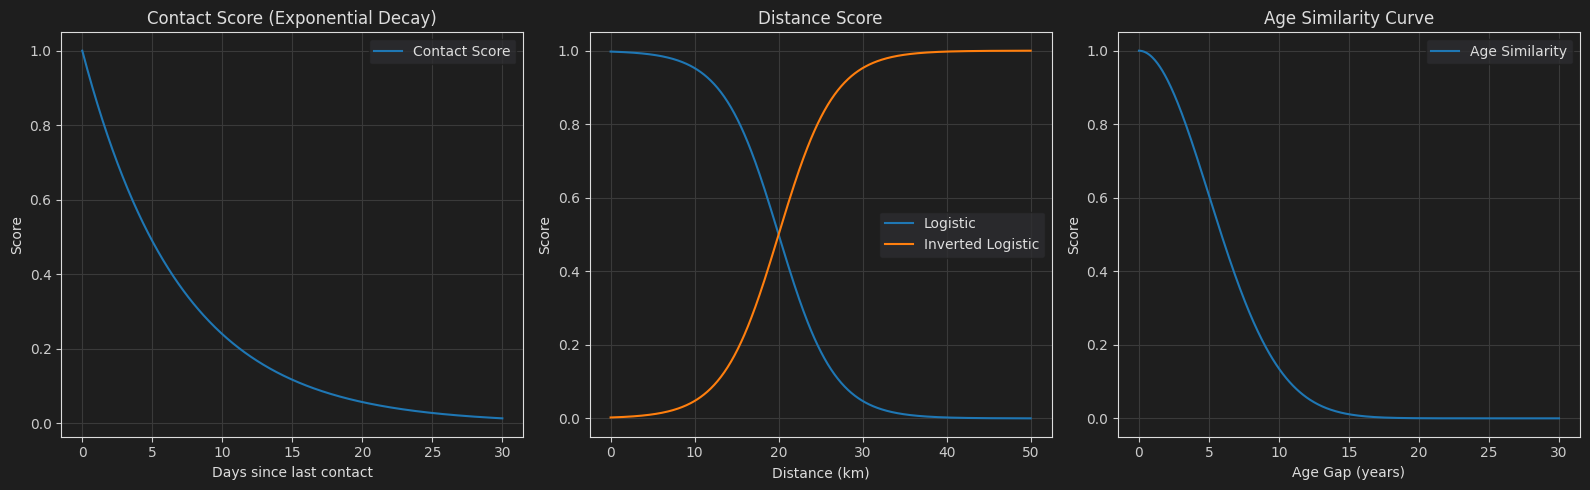

In [105]:
# normalization Graphs for scores
show_graphs = True

if show_graphs:
    import matplotlib.pyplot as plt
    import numpy as np

    # VS Code dark-like colors
    plt.rcParams.update({
        "axes.facecolor": "#1e1e1e",   # VS Code editor background
        "figure.facecolor": "#1e1e1e",
        "axes.edgecolor": "#DDDDDD",
        "axes.labelcolor": "#DDDDDD",
        "xtick.color": "#CCCCCC",
        "ytick.color": "#CCCCCC",
        "text.color": "#DDDDDD",
        "grid.color": "#3a3a3a",       # subtle dark grid
        "legend.edgecolor": "#1e1e1e",
        "legend.facecolor": "#2d2d30"
    })

    # Contact score curve (geometric normalization)
    def contact_score_curve(seconds, half_life=7*24*3600):
        return np.exp(-seconds / half_life)

    # Distance score (logistic normal)
    def distance_score_logistic(distance, k=0.3, midpoint=20):
        return 1 / (1 + np.exp(k * (distance - midpoint)))

    # Distance score (logistic inverted)
    def distance_score_inverted(distance, k=0.3, midpoint=20):
        return 1 - distance_score_logistic(distance, k, midpoint)
    
    # Age similarity curve
    def age_similarity(gap, sigma=5):
        return np.exp(-(gap**2) / (2*sigma**2))

    # Generate ranges
    time_range = np.linspace(0, 30*24*3600, 500)   # 0–30 days in seconds
    distance_range = np.linspace(0, 50, 500)       # 0–50 km
    age_gap_range = np.linspace(0, 30, 500)        # 0–30 years

    # Calculate scores
    contact_scores = contact_score_curve(time_range)
    distance_log = distance_score_logistic(distance_range)
    distance_inv = distance_score_inverted(distance_range)
    age_scores = [age_similarity(g) for g in age_gap_range]

    # Plot Contact Score
    plt.figure(figsize=(16,5))

    plt.subplot(1,3,1)
    plt.plot(time_range/(24*3600), contact_scores, label="Contact Score")
    plt.title("Contact Score (Exponential Decay)")
    plt.xlabel("Days since last contact")
    plt.ylabel("Score")
    plt.grid(True)
    plt.legend()

    # Plot Distance Score
    plt.subplot(1,3,2)
    plt.plot(distance_range, distance_log, label="Logistic")
    plt.plot(distance_range, distance_inv, label="Inverted Logistic")
    plt.title("Distance Score")
    plt.xlabel("Distance (km)")
    plt.ylabel("Score")
    plt.grid(True)
    plt.legend()

    # Plot Age Similarity Score
    plt.subplot(1,3,3)
    plt.plot(age_gap_range, age_scores, label="Age Similarity")
    plt.title("Age Similarity Curve")
    plt.xlabel("Age Gap (years)")
    plt.ylabel("Score")
    plt.grid(True)
    plt.legend()

    plt.tight_layout()
    plt.show()

# Hobby Clusters (t-SNE + KMeans)
<img src="data/tsne_clusters.png">

**Total hobbies:** 218 · **Clusters:** 10

<span style="color:#2ca02c">**Cluster 2 (42):** Animal rescue • Astronomy • Backpacking • Birdwatching • Bouldering • Bridge • Butterfly watching • Camping • Canoeing • Climbing • Dog walking • Drone flying • Falconry • Fishing • Free diving • Geocaching • Go • Hiking • Horseback riding • Kayaking • Kite flying • LARPing • Longboarding • Meteorology • Mountaineering • Overlanding • Parkour • Pigeon racing • Running • Sailing • Scootering • Scuba diving • Snorkeling • Snowboarding • Speedrunning • Stargazing • Streaming • Surfing • Swimming • Traveling • Van life • Volunteering</span>

<span style="color:#c7c7c7">**Cluster 7 (32):** Animation • Baking • Blacksmithing • Candle making • Carving • Clowning • Coffee roasting • Cooking • Cosplay • Crocheting • Drawing • Film making • Glassblowing • Hair styling • Homebrewing • Ikebana • Jewelry making • Knitting • Makeup artistry • Nail art • Origami • Painting • Photography • Pottery • Puppetry • Sculpting • Soap making • Tea blending • Video editing • Vlogging • Winemaking • Woodworking</span>

<span style="color:#d62728">**Cluster 3 (30):** Airsoft • Bodybuilding • Boxing • Callisthenics • Dancing • Dog training • Fencing • Gymnastics • Ice skating • Jiu-jitsu • Judo • Juggling • Karate • Kickboxing • Magic tricks • Martial arts • Meditation • Mindfulness • Muay Thai • Pilates • Powerlifting • Roller skating • Shooting • Skateboarding • Spinning • Taekwondo • Trampolining • Wrestling • Yoga • Zumba</span>

<span style="color:#9467bd">**Cluster 4 (23):** Archery • Backgammon • Badminton • Baseball • Basketball • Checkers • Chess • Dominoes • Football • Hockey • Lacrosse • Mahjong • Paintball • Pickleball • Playing guitar • Playing piano • Poker • Rugby • Soccer • Softball • Squash • Table tennis • Tennis</span>

<span style="color:#1f77b4">**Cluster 0 (20):** 3D printing • App development • Coding • DIY home projects • Electronics • Embroidery • Fashion design • Furniture restoration • Graphic design • Hacking • Interior design • Leathercraft • Lego building • Metalworking • Model building • Programming • Robotics • Sewing • Social media content creation • Web design</span>

<span style="color:#f7b6d2">**Cluster 6 (18):** Blogging • Calligraphy • Creative writing • Debating • Improv • Language learning • Philosophy study • Playwriting • Podcasting • Poetry • Public speaking • Reading • Screenwriting • Short stories • Singing • Stand-up comedy • Whittling • Writing</span>

<span style="color:#ff7f0e">**Cluster 1 (15):** Aerobics • Biathlon • Cheerleading • Cross-country skiing • CrossFit • Cycling • Duathlon • Ironman • RC boats • RC cars • RC planes • Rowing • Skiing • Triathlon • Weightlifting</span>

<span style="color:#c49c94">**Cluster 5 (13):** Charity work • Collecting antiques • Collecting cards • Collecting coins • Collecting comics • Collecting stamps • Collecting toys • Fossil hunting • Genealogy • History research • Insect collecting • Mushroom foraging • Rock collecting</span>

<span style="color:#9edae5">**Cluster 9 (13):** Aquaponics • Aquarium keeping • Beekeeping • Bonsai • Cat care • Community gardening • Gardening • Herbalism • Houseplant care • Hydroponics • Permaculture • Reef keeping • Urban farming</span>

<span style="color:#dbdb8d">**Cluster 8 (12):** Board games • Card games • Dungeons &amp; Dragons • Esports • Fantasy sports • Game development • Game modding • Magic: The Gathering • Mythology studies • Role-playing games • Tabletop RPGs • Video gaming</span>


# Heatmap - 20 hobbies, example
<img src="data/heatmap_20.png" width="60%">